# Прогноз оттока клиентов

<big><b>Описание проекта</b></big>

<b>Цель:</b> Оператору связи "ТелеДом" необходимо прогнозировать отток клиентов, чтобы планировать превентивные меры для удержания клиентов.

Для некоторых клиентов доступны персональные данные, информация о тарифах и договорах.

Основная метрика для оценки модели: ROC-AUC

<big><b>Описание услуг</b></big>

* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

<big><b>Дополнительные услуги</b></big>

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

<big><b>Описание данных</b></big>

Данные состоят из нескольких файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

## Исследовательский анализ данных

### Загрузка данных

In [1]:
!pip install phik
!pip install -Uq scikit-learn
!pip install matplotlib==3.5.0 -q

In [2]:
import time
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV
# загружаем нужные классы
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
# загружаем нужные метрики
from sklearn.metrics import (
    roc_auc_score, 
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix,
    roc_curve
)
# импортируем модели
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

In [3]:
contract = pd.read_csv('/datasets/contract_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

### Предобработка данных

#### contract

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract.duplicated().sum()

0

<b>Дубликатов нет.</b>

In [6]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

<b>Пропусков нет.</b>

In [7]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<b>TotalCharges необходимо привести к типу float</b>

In [8]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

<b>Признаки BeginDate и EndDate содержат дату начала и окончания контракта. На их основе можно создать два признака с состоянием контракта и его продолжительностью. Они будут называться contract_condition и contract_duration.</b>

In [9]:
contract['contract_condition'] = 1
contract.loc[contract['EndDate'] == 'No', 'contract_condition'] = 0

In [10]:
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')

<b>Если EndDate содержит No, значит договор был активен 01.02.2020. Заменим No на эту дату.</b>

In [11]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract['EndDate'] = contract['EndDate'].astype('datetime64')

In [12]:
contract['contract_duration'] = (contract['EndDate'] - contract['BeginDate']).dt.components.days

In [13]:
contract = contract.drop(['BeginDate', 'EndDate'], axis=1)

<b>Приведём все столбцы к одному регистру</b>

In [14]:
contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in contract.columns] 
contract = contract.rename(columns={'customer_i_d':'customer_id'})

In [15]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   type                7043 non-null   object 
 2   paperless_billing   7043 non-null   object 
 3   payment_method      7043 non-null   object 
 4   monthly_charges     7043 non-null   float64
 5   total_charges       7043 non-null   float64
 6   contract_condition  7043 non-null   int64  
 7   contract_duration   7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


In [16]:
contract.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_condition,contract_duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


#### personal

In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [19]:
personal.duplicated().sum()

0

<b>Дубликатов нет.</b>

In [20]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

<b>Пропусков нет.</b>

<b>По какой-то причине признак SeniorCitizen имеет числовые значения, в отличие от своих собратьев-признаков, у которых категориальные значения. Превратим признак SeniorCitizen в категориальный.</b>

In [21]:
personal.loc[personal['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
personal.loc[personal['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

<b>Приведём все названия к одному регистру.</b>

In [22]:
personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in personal.columns] 
personal = personal.rename(columns={'customer_i_d':'customer_id'})

In [23]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [24]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


#### internet

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [27]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

<b>Пропусков нет.</b>

In [28]:
internet.duplicated().sum()

0

<b>Дубликатов нет.</b>

<b>Приведём все названия признаков к одному регистру.</b>

In [29]:
internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in internet.columns] 
internet = internet.rename(columns={
    'customer_i_d':'customer_id', 
    'streaming_t_v':'streaming_tv'
})

In [30]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [31]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


#### phone

In [32]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [33]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [34]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

<b>Пропусков нет.</b>

In [35]:
phone.duplicated().sum()

0

<b>Явные дубликаты.</b>

<b>Приведём все столбцы к одному регистру.</b>

In [36]:
phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in phone.columns] 
phone = phone.rename(columns={'customer_i_d':'customer_id'})

In [37]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [38]:
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Объединение данных

In [39]:
total = personal.join(contract.set_index('customer_id'), on='customer_id')
total = total.join(internet.set_index('customer_id'), on='customer_id', how='left')
total = total.join(phone.set_index('customer_id'), on='customer_id', how='left')

In [40]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   gender              7043 non-null   object 
 2   senior_citizen      7043 non-null   object 
 3   partner             7043 non-null   object 
 4   dependents          7043 non-null   object 
 5   type                7043 non-null   object 
 6   paperless_billing   7043 non-null   object 
 7   payment_method      7043 non-null   object 
 8   monthly_charges     7043 non-null   float64
 9   total_charges       7043 non-null   float64
 10  contract_condition  7043 non-null   int64  
 11  contract_duration   7043 non-null   int64  
 12  internet_service    5517 non-null   object 
 13  online_security     5517 non-null   object 
 14  online_backup       5517 non-null   object 
 15  device_protection   5517 non-null   object 
 16  tech_s

In [41]:
total.head()

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_condition,contract_duration,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,One year,No,Mailed check,56.95,2071.84,0,1036,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Fiber optic,No,No,No,No,No,No,No


<b>Значения NaN, можно интерпретировать как No (отсутствие значения).</b>

In [42]:
total = total.fillna('No')

### Разделение данных на выборки

<b>В качестве целевого признака выберем contract_condition</b>

In [43]:
X = total.drop('contract_condition', axis=1)
y = total['contract_condition']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=300625)

<b>Объединим тренировочные выборки в одну</b>

In [45]:
total_train = X_train.join(y_train)

In [46]:
total_train.shape

(5282, 20)

In [47]:
total_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2190 to 5311
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         5282 non-null   object 
 1   gender              5282 non-null   object 
 2   senior_citizen      5282 non-null   object 
 3   partner             5282 non-null   object 
 4   dependents          5282 non-null   object 
 5   type                5282 non-null   object 
 6   paperless_billing   5282 non-null   object 
 7   payment_method      5282 non-null   object 
 8   monthly_charges     5282 non-null   float64
 9   total_charges       5282 non-null   float64
 10  contract_duration   5282 non-null   int64  
 11  internet_service    5282 non-null   object 
 12  online_security     5282 non-null   object 
 13  online_backup       5282 non-null   object 
 14  device_protection   5282 non-null   object 
 15  tech_support        5282 non-null   object 
 16  str

In [48]:
total_train.describe()

,monthly_charges,total_charges,contract_duration,contract_condition
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,64.921090,2122.432914,900.359523,0.152783
std,30.087378,2124.818830,687.044445,0.359812
min,18.550000,0.000000,0.000000,0.000000
25%,35.800000,435.887500,276.000000,0.000000
50%,70.550000,1340.570000,761.000000,0.000000
75%,89.900000,3245.437500,1461.000000,0.000000
max,118.750000,9218.880000,2314.000000,1.000000


### Исследовательский анализ total_train

In [49]:
total_new_features = {
    'customer_id':'идентификатор абонента',
    'gender':'пол',
    'senior_citizen':'является ли абонент пенсионером',
    'partner':'есть ли у абонента супруг или супруга',
    'dependents':'есть ли у абонента дети',

    'type':'тип оплаты',
    'paperless_billing':'электронный расчётный лист',
    'payment_method':'тип платежа',
    'monthly_charges':'расходы за месяц',
    'total_charges':'общие расходы абонента',
    'contract_condition':'активный договор (целевой признак)', 
    'contract_duration':'продолжительность договора в днях',

    'internet_service':'тип подключения',
    'online_security':'блокировка опасных сайтов',
    'online_backup':'облачное хранилище файлов для резервного копирования данных',
    'device_protection':'антивирус',
    'tech_support':'выделенная линия технической поддержки',
    'streaming_tv':'стриминговое телевидение',
    'streaming_movies':'каталог фильмов',

    'multiple_lines':'подключение телефона к нескольким линиям одновременно'
}

Распределение значений признака "gender" (пол):


,count,unique,top,freq
Класс 0,4475,2,Male,2254
Класс 1,807,2,Male,420


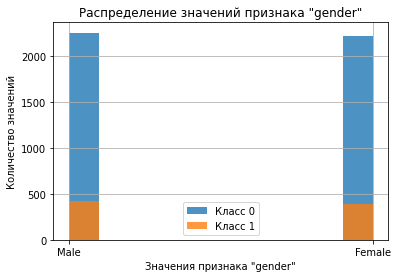

Распределение значений признака "senior_citizen" (является ли абонент пенсионером):


,count,unique,top,freq
Класс 0,4475,2,No,3777
Класс 1,807,2,No,633


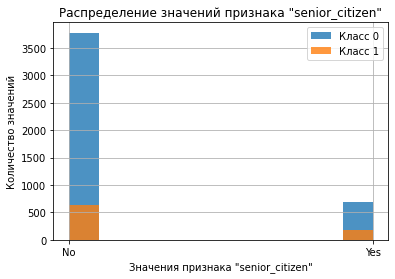

Распределение значений признака "partner" (есть ли у абонента супруг или супруга):


,count,unique,top,freq
Класс 0,4475,2,No,2475
Класс 1,807,2,Yes,528


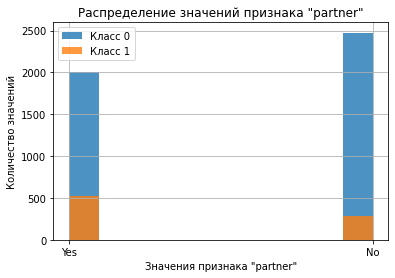

Распределение значений признака "dependents" (есть ли у абонента дети):


,count,unique,top,freq
Класс 0,4475,2,No,3175
Класс 1,807,2,No,539


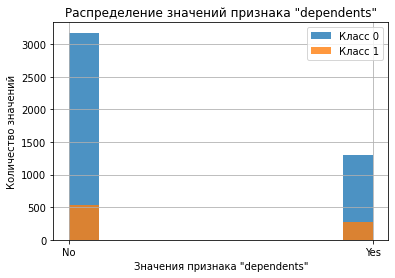

Распределение значений признака "type" (тип оплаты):


,count,unique,top,freq
Класс 0,4475,3,Month-to-month,2617
Класс 1,807,3,Month-to-month,304


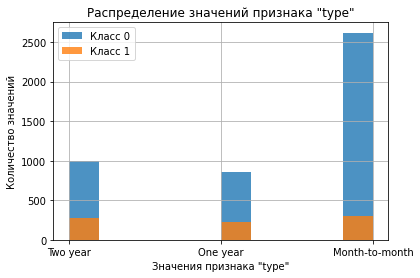

Распределение значений признака "paperless_billing" (электронный расчётный лист):


,count,unique,top,freq
Класс 0,4475,2,Yes,2631
Класс 1,807,2,Yes,536


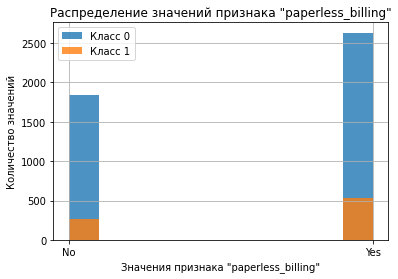

Распределение значений признака "payment_method" (тип платежа):


,count,unique,top,freq
Класс 0,4475,4,Electronic check,1530
Класс 1,807,4,Electronic check,265


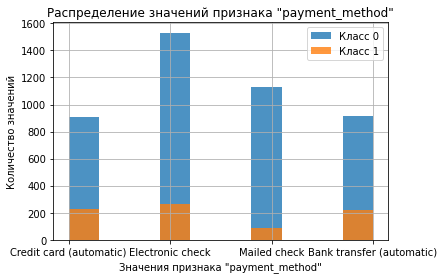

Распределение значений признака "monthly_charges" (расходы за месяц):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4475.0,62.984894,29.828153,18.55,30.675,69.50,87.975,118.60
Класс 1,807.0,75.657745,29.263536,18.80,56.050,84.15,99.800,118.75


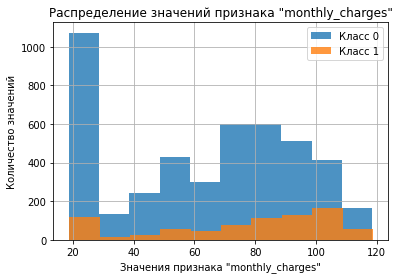

Распределение значений признака "total_charges" (общие расходы абонента):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4475.0,2086.226311,2210.583904,0.00,374.680,1198.40,3198.815,9218.88
Класс 1,807.0,2323.206828,1552.050290,77.84,1037.075,2078.35,3340.800,7567.56


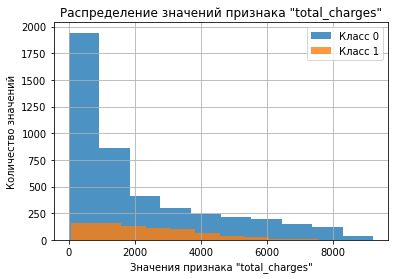

Распределение значений признака "contract_duration" (продолжительность договора в днях):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4475.0,898.886927,721.443168,0.0,245.0,702.0,1523.0,2314.0
Класс 1,807.0,908.525403,451.216529,28.0,549.0,913.0,1247.0,2070.0


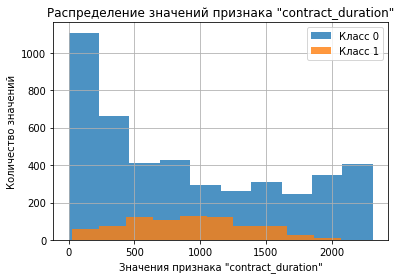

Распределение значений признака "internet_service" (тип подключения):


,count,unique,top,freq
Класс 0,4475,3,Fiber optic,1891
Класс 1,807,3,Fiber optic,435


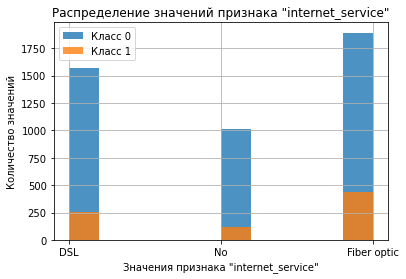

Распределение значений признака "online_security" (блокировка опасных сайтов):


,count,unique,top,freq
Класс 0,4475,2,No,3255
Класс 1,807,2,No,508


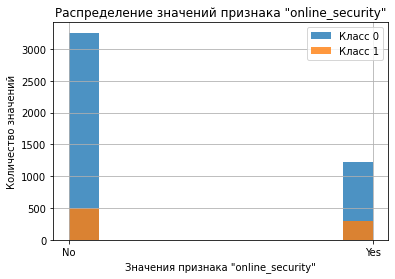

Распределение значений признака "online_backup" (облачное хранилище файлов для резервного копирования данных):


,count,unique,top,freq
Класс 0,4475,2,No,3062
Класс 1,807,2,Yes,409


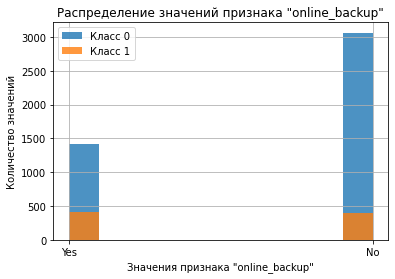

Распределение значений признака "device_protection" (антивирус):


,count,unique,top,freq
Класс 0,4475,2,No,3059
Класс 1,807,2,Yes,405


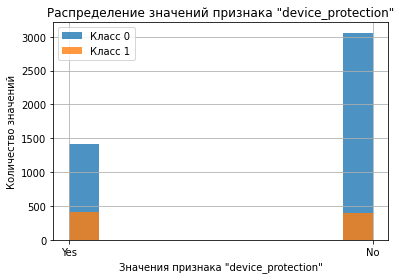

Распределение значений признака "tech_support" (выделенная линия технической поддержки):


,count,unique,top,freq
Класс 0,4475,2,No,3220
Класс 1,807,2,No,517


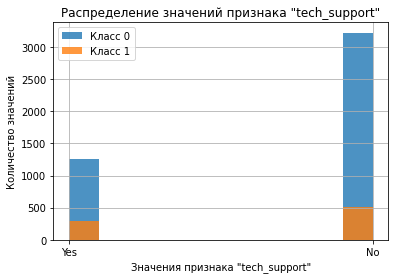

Распределение значений признака "streaming_tv" (стриминговое телевидение):


,count,unique,top,freq
Класс 0,4475,2,No,2872
Класс 1,807,2,Yes,437


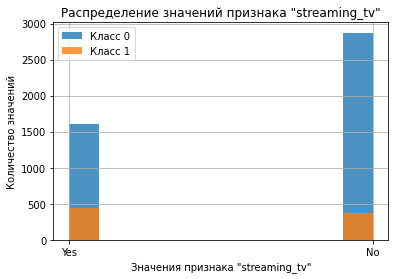

Распределение значений признака "streaming_movies" (каталог фильмов):


,count,unique,top,freq
Класс 0,4475,2,No,2852
Класс 1,807,2,Yes,454


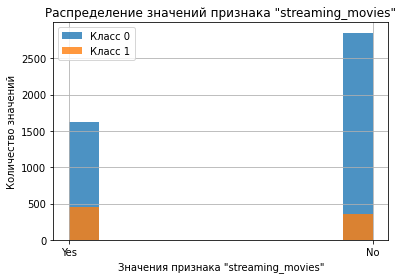

Распределение значений признака "multiple_lines" (подключение телефона к нескольким линиям одновременно):


,count,unique,top,freq
Класс 0,4475,2,No,2772
Класс 1,807,2,Yes,489


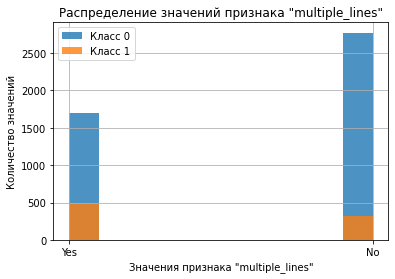

Распределение значений признака "contract_condition" (активный договор (целевой признак)):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4475.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Класс 1,807.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


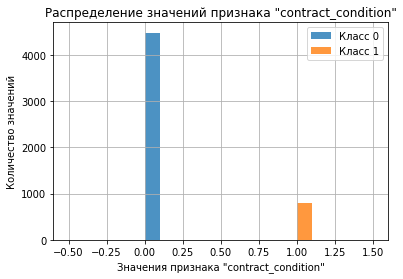

In [50]:
for i in total_train.columns:
    if i not in ['customer_id']:
        for j in total_train:
            if i == j:
                print(f'Распределение значений признака "{i}" ({total_new_features[j]}):')
                
                t0 = total_train.loc[total_train['contract_condition'] == 0, i] 
                t1 = total_train.loc[total_train['contract_condition'] == 1, i] 
                
                t0 = t0.rename('Класс 0') 
                t1 = t1.rename('Класс 1') 
                
                display(pd.DataFrame([t0.describe(), t1.describe()])) 
                
                t0.hist(legend=True, alpha=.8)
                t1.hist(legend=True, alpha=.8) 
                plt.title(f'Распределение значений признака "{i}"')
                plt.xlabel(f'Значения признака "{i}"')
                plt.ylabel('Количество значений')
                plt.show() 

    Мужчин и женщин примерно поровну.
    Пенсионеров очень мало.
    Состоящих в браке людей меньше, чем свободных. Их контракты чаще разрываются.
    Клиентов, у которых есть дети, меньше, чем бездетных. Их контракты разрываются чаще, чем у клиентов без детей.
    Большинство клиентов платят помесячно.
    Больше всего клиентов платят электронным способом, реже всего - кредитной картой.
    По типу подключения побеждает оптоволокно, клиентов с ним - большинство.
    Клиентов с блокировкой опасных сайтов меньше, чем клиентов без блокировки. Клиенты без блокировки уходят чаще.
    Клиентов без облачного хранилища больше, чем клиентов без него. Они уходят примерно одинаково.
    Клиентов без антивируса меньше, чем с антивирусом.
    Клиентов без технической поддержки больше, чем с ней.
    Клиентов без стримингового телевидения больше, чем с ним. Клиенты со стриминговым телевидением уходят чаще.
    Пользующиеся стримингом фильмов уходят чаще.
    Пользующиеся многоканальной телефонией уходят чаще.


### Мультиколлинеарность в total_train

In [51]:
total_train_num = ['monthly_charges', 'total_charges', 'contract_duration']

In [52]:
total_train_cat = []

for i in total_train.columns:
    if (i not in total_train_num) & (i not in ['customer_id', 'contract_condition']):
        total_train_cat.append(i)

In [53]:
total_train.drop('customer_id', axis=1)[total_train_num].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2190 to 5311
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   monthly_charges    5282 non-null   float64
 1   total_charges      5282 non-null   float64
 2   contract_duration  5282 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 294.1 KB


,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_condition
gender,1.000000,0.000000,0.000000,0.016108,0.009208,0.017264,0.011135,0.000000,0.000000,0.000000,0.000000,0.013743,0.005799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.000000,1.000000,0.024029,0.320307,0.088989,0.236547,0.293180,0.307358,0.146498,0.064664,0.162940,0.052841,0.110100,0.081147,0.080834,0.145510,0.179140,0.230422,0.086919
partner,0.000000,0.024029,1.000000,0.652783,0.186938,0.008929,0.246448,0.208479,0.409920,0.482618,0.000000,0.248334,0.236586,0.235980,0.191371,0.203050,0.191926,0.234131,0.230672
dependents,0.016108,0.320307,0.652783,1.000000,0.154919,0.168735,0.234333,0.183967,0.107397,0.219633,0.106092,0.135329,0.055669,0.014300,0.094524,0.000000,0.050269,0.027053,0.045675
type,0.009208,0.088989,0.186938,0.154919,1.000000,0.105944,0.278889,0.391734,0.480695,0.636972,0.506609,0.152517,0.099279,0.140192,0.183752,0.072718,0.072699,0.066035,0.090380
paperless_billing,0.017264,0.236547,0.008929,0.168735,0.105944,1.000000,0.373644,0.461549,0.194261,0.000000,0.229332,0.000000,0.196809,0.151979,0.043098,0.330044,0.312278,0.255205,0.084291
payment_method,0.011135,0.293180,0.246448,0.234333,0.278889,0.373644,1.000000,0.400959,0.335789,0.353292,0.323399,0.272907,0.276945,0.313844,0.260401,0.372326,0.391052,0.335441,0.200704
monthly_charges,0.000000,0.307358,0.208479,0.183967,0.391734,0.461549,0.400959,1.000000,0.707376,0.377666,0.918595,0.553220,0.624203,0.672446,0.573021,0.834703,0.842027,0.676415,0.222901
total_charges,0.000000,0.146498,0.409920,0.107397,0.480695,0.194261,0.335789,0.707376,1.000000,0.848051,0.483509,0.520365,0.614815,0.639969,0.554734,0.637435,0.646179,0.571188,0.298996
contract_duration,0.000000,0.064664,0.482618,0.219633,0.636972,0.000000,0.353292,0.377666,0.848051,1.000000,0.060681,0.401162,0.414642,0.425694,0.414614,0.337813,0.341971,0.392881,0.382846


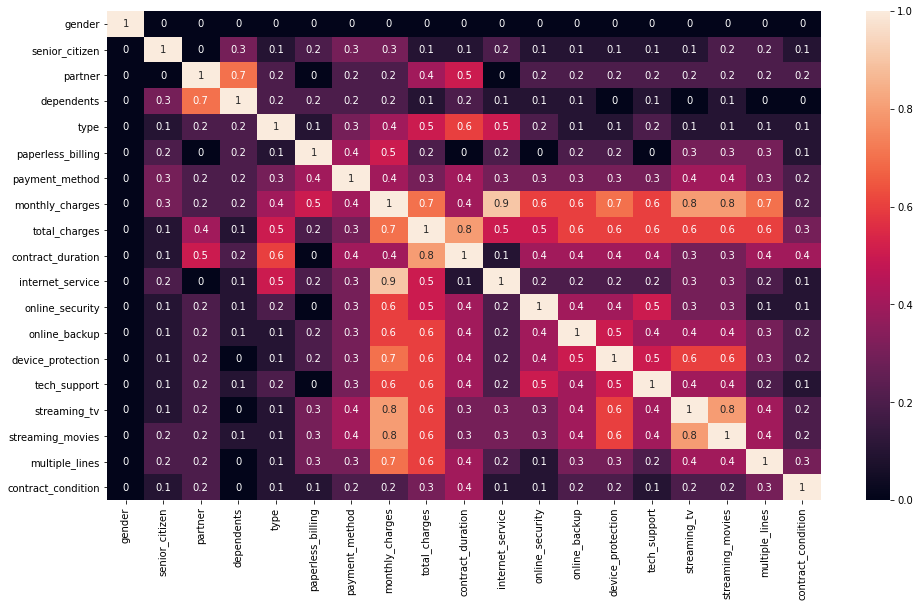

In [54]:
multicol = total_train.drop('customer_id', axis=1).phik_matrix(interval_cols=total_train_num)
display(multicol)

plt.figure(figsize=(16, 9))
sns.heatmap(multicol.copy().round(1), annot=True)
plt.show()

<b>Мультиколлинеарность присутствует, например между признаками internet_service и monthly_charges.</b>

<b>Отберём те признаки, у которых корелляция с целевым признаком больше всего (от 0.15). Также отбросим те признаки, у которых мультиколлинеарность больше 0.7</b>

In [55]:
def non_multicollinear_features(m, target_feature, v_min, v_max):
    
    columns = [] 
    append = True
    
    for c in m.columns:
        if ((m[c][target_feature] > v_min) & (c != target_feature)): 
            for i in m.index:
                if ((c != i) & (c != target_feature) & (c not in columns) & (i not in columns)):
                    if m[c][i] > v_max:
                        if m[c][target_feature] < m[i][target_feature]:
                            append = False
                            break
            if append == True: columns.append(c) 
            append = True 
    
    return columns

columns = non_multicollinear_features(multicol, 'contract_condition', 0.2, 0.75)

print('Не мультиколлинеарные признаки, обладающие статистически значимой парной корреляцией с целевым признаком:')
columns

Не мультиколлинеарные признаки, обладающие статистически значимой парной корреляцией с целевым признаком:


['partner',
 'payment_method',
 'contract_duration',
 'online_backup',
 'device_protection',
 'streaming_movies',
 'multiple_lines']

<b>Разделим признаки на количественные и категориальные.</b>

In [56]:
cat_features = []
for i in columns:
    for j in total_train_cat:
        if i == j: cat_features.append(i)

num_features = []
for i in columns:
    for j in total_train_num:
        if i == j: num_features.append(i)

<b>Категориальные признаки:</b>

In [57]:
cat_features

['partner',
 'payment_method',
 'online_backup',
 'device_protection',
 'streaming_movies',
 'multiple_lines']

<b>Количественные признаки:</b>

In [58]:
num_features

['contract_duration']

## Обучение моделей

### Подготовка данных

In [59]:
X_train = X_train[columns]
X_test = X_test[columns]

<b>Посмотрим на то, что мы сделали.</b>

In [60]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2190 to 5311
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   partner            5282 non-null   object
 1   payment_method     5282 non-null   object
 2   contract_duration  5282 non-null   int64 
 3   online_backup      5282 non-null   object
 4   device_protection  5282 non-null   object
 5   streaming_movies   5282 non-null   object
 6   multiple_lines     5282 non-null   object
dtypes: int64(1), object(6)
memory usage: 459.2+ KB


In [61]:
X_train.head()

,partner,payment_method,contract_duration,online_backup,device_protection,streaming_movies,multiple_lines
2190,Yes,Credit card (automatic),2163,Yes,Yes,Yes,Yes
5074,No,Credit card (automatic),1492,No,No,No,No
530,Yes,Credit card (automatic),730,No,No,No,No
3837,No,Electronic check,184,Yes,Yes,Yes,No
2929,No,Mailed check,1218,Yes,No,No,No


In [62]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 4631 to 5082
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   partner            1761 non-null   object
 1   payment_method     1761 non-null   object
 2   contract_duration  1761 non-null   int64 
 3   online_backup      1761 non-null   object
 4   device_protection  1761 non-null   object
 5   streaming_movies   1761 non-null   object
 6   multiple_lines     1761 non-null   object
dtypes: int64(1), object(6)
memory usage: 110.1+ KB


In [63]:
X_test.head()

,partner,payment_method,contract_duration,online_backup,device_protection,streaming_movies,multiple_lines
4631,No,Electronic check,215,No,Yes,No,Yes
2291,No,Electronic check,245,No,No,No,Yes
6856,Yes,Credit card (automatic),1767,No,No,No,Yes
754,Yes,Electronic check,62,Yes,No,No,No
3795,No,Electronic check,365,No,No,No,No


### Пайплайны

In [64]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features),
        ('num', MinMaxScaler(), num_features)
    ], 
    remainder='passthrough'
)

In [65]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

### Обучение моделей

In [66]:
param_distributions_lr = [ 
    {
        'model': [LogisticRegression(max_iter=1500, random_state=42, class_weight='balanced')],
        'model__solver': ['newton-cg', 'lbfgs', 'sag'],
        'model__penalty': ['l2'],
        'model__C': [0.2, 0.5, 1, 2, 3, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=42, class_weight='balanced')],
        'model__solver': ['liblinear', 'saga'],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.2, 0.5, 1, 2, 3, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=42, class_weight='balanced')],
        'model__solver': ['saga'],
        'model__penalty': ['elasticnet'],
        'model__l1_ratio': [0.0, 0.5, 1.0],
        'model__C': [0.2, 0.5, 1, 2, 3, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [67]:
param_distributions_rf = [
    {
        'model': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'model__n_estimators': [100, 200, 300, 500],
        'model__max_depth': [None, 4, 6, 7, 8, 9, 10, 11, 12],
        'model__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14],
        'model__min_samples_split': [2, 4, 6, 8, 10, 12, 14],
        'model__max_features': ['sqrt', 'log2', None],
        'model__bootstrap': [True, False],
        'preprocessor__num': ['passthrough']     
    }
]

In [68]:
X_LGBM_train = X_train.copy()
X_LGBM_test = X_test.copy()
for cat in cat_features:
    X_LGBM_train[cat] = X_LGBM_train[cat].astype('category').cat.codes
    X_LGBM_test[cat] = X_LGBM_test[cat].astype('category').cat.codes

param_distributions_LGBM = [
    {
        'model': [LGBMClassifier(random_state=300625, verbosity=-1, class_weight='balanced')],
        'model__n_estimators': [300, 500, 700, 900, 1000, 1100, 1200],
        'model__learning_rate': [0.1, 0.2, 0.25],
        'model__max_depth': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': ['passthrough']
    }
]

In [69]:
%%time
cv_LGBM = RandomizedSearchCV(
    pipe_final, 
    param_distributions_LGBM, 
    scoring='roc_auc', 
    n_iter=100,
    n_jobs=-1,
    random_state=300625,
    verbose=10  # <-- Добавьте эту строку для вывода прогресса
)
cv_LGBM.fit(X_LGBM_train, y_train)
print('Метрика ROC_AUC для лучшей модели LGBMClassifier:', abs(cv_LGBM.best_score_))
print('Лучшая модель LGBMClassifier и её параметры:\n', cv_LGBM.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model=LGBMClassifier(class_weight='balanced', random_state=300625, verbosity=-1), model__learning_rate=0.25, model__max_depth=3, model__n_estimators=700, preprocessor__cat=passthrough, preprocessor__num=RobustScaler()
[CV 1/5; 1/100] END model=LGBMClassifier(class_weight='balanced', random_state=300625, verbosity=-1), model__learning_rate=0.25, model__max_depth=3, model__n_estimators=700, preprocessor__cat=passthrough, preprocessor__num=RobustScaler();, score=0.908 total time=   1.9s
[CV 2/5; 1/100] START model=LGBMClassifier(class_weight='balanced', random_state=300625, verbosity=-1), model__learning_rate=0.25, model__max_depth=3, model__n_estimators=700, preprocessor__cat=passthrough, preprocessor__num=RobustScaler()
[CV 2/5; 1/100] END model=LGBMClassifier(class_weight='balanced', random_state=300625, verbosity=-1), model__learning_rate=0.25, model__max_depth=3, model__n_estimators=700, preprocessor

In [70]:
%%time
cv_lr = RandomizedSearchCV(
    pipe_final, 
    param_distributions_lr, 
    scoring='roc_auc',
    n_iter=150,
    n_jobs=-1,
    random_state=300625,
    verbose=1
)
cv_lr.fit(X_train, y_train)
print('Метрика ROC_AUC для лучшей модели LogisticRegression:', abs(cv_lr.best_score_))
print('Лучшая модель LogisticRegression и её параметры:\n', cv_lr.best_estimator_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Метрика ROC_AUC для лучшей модели LogisticRegression: 0.7217285407132382
Лучшая модель LogisticRegression и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['partner', 'payment_method',
                                                   'online_backup',
                                                   'device_protection',
                                                   'streaming_movies',
                                                   'multiple_lines']),
                                                 ('num', 'passthrough',
                                                  ['contract_durat

In [71]:
%%time
cv_tree = RandomizedSearchCV(
    pipe_final, 
    param_distributions_rf, 
    scoring='roc_auc', 
    n_iter=150,
    n_jobs=-1,
    random_state=300625
)
cv_tree.fit(X_train, y_train)
print('Метрика ROC_AUC для лучшей модели RandomForestClassifier:', abs(cv_tree.best_score_))
print('Лучшая модель RandomForestClassifier и её параметры:\n', cv_tree.best_estimator_)

Метрика ROC_AUC для лучшей модели RandomForestClassifier: 0.8285756910200275
Лучшая модель RandomForestClassifier и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['partner', 'payment_method',
                                                   'online_backup',
                                                   'device_protection',
                                                   'streaming_movies',
                                                   'multiple_lines']),
                                                 ('num', 'passthrough',
                                                  ['contract_duration'])])),
                ('model',
                 R

## Тестирование и анализ модели

<b>По метрике ROC-AUC побеждает случайный лес.</b>

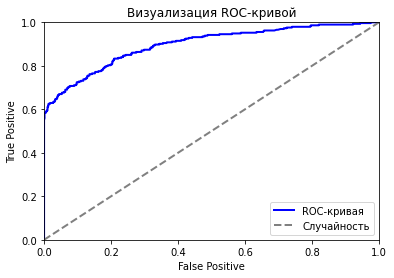

In [76]:
fpr, tpr, thresholds = roc_curve(y_test, cv_LGBM.predict_proba(X_LGBM_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-кривая')
plt.plot([0, 1], [0, 1], color='gray', lw=2, label='Случайность', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('Визуализация ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [77]:
print(f'Метрика Accuracy на тестовой выборке: {accuracy_score(y_test, cv_LGBM.predict(X_LGBM_test))}')

Метрика Accuracy на тестовой выборке: 0.8523566155593413


Количество элементов в тестовой выборке: 1761


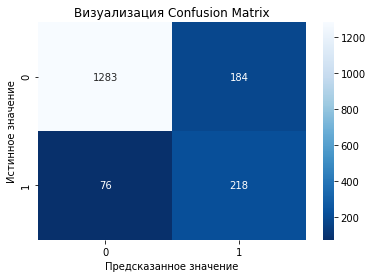

In [78]:
cm = confusion_matrix(y_test, cv_LGBM.predict(X_LGBM_test))
print(f'Количество элементов в тестовой выборке: {len(y_test)}')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Визуализация Confusion Matrix')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказанное значение');

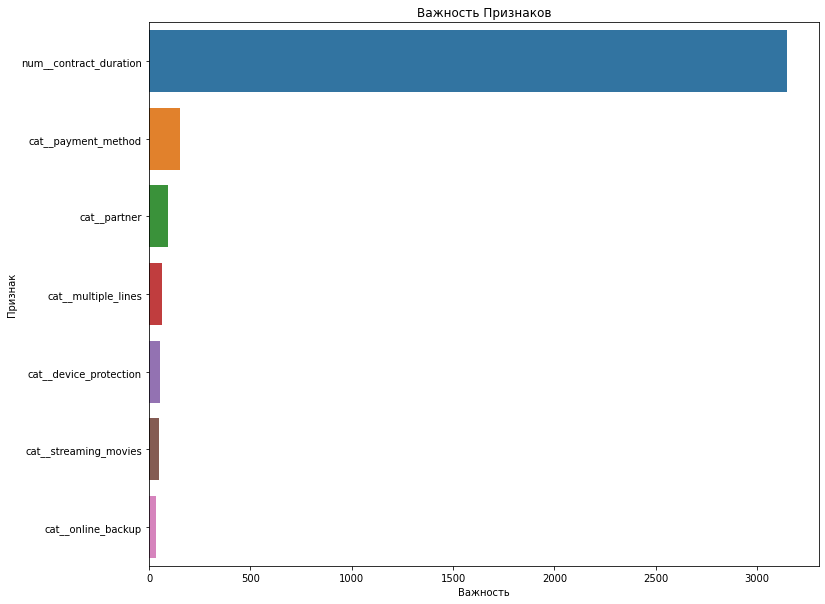

In [86]:
feature_names = cv_LGBM.best_estimator_[:1].get_feature_names_out()
feature_importances = cv_LGBM.best_estimator_[-1].booster_.feature_importance(importance_type='split')

df_fi = pd.DataFrame({'Признак': feature_names, 'Важность': feature_importances_split})
df_fi = df_fi_s.sort_values(by='Важность', ascending=False)

fig, ax = plt.subplots(figsize=(12, 10))

sns.barplot(x='Важность', y='Признак', data=df_fi, ax=ax)
ax.set_title('Важность Признаков')
plt.show()

<b>С большим отрывом по значимости побеждает признак multiple_lines - подключение телефона к нескольким линиям одновременно. (По-моему я где-то совершил катастрофическую ошибку, ментор, помогите мне)))</b>

# Общий вывод

1. Все шаги были выполнены. (Загрузка - предпосмотр - объеденение - анализ датасета, подготовка данных - обучение модели - анализ лучшей модели - вывод)
2. Мы создали целевой признак из уже имеющихся признаков.
3. Некоторые признаки, например, пол клиента, абсолютно бесполезны.
4. Были обучены следующие модели: LogisticRegression, RandomForestClassifier, LGMB
5. Параметры лучшей модели: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', 'passthrough',
                                                  ['partner', 'payment_method',
                                                   'online_backup',
                                                   'device_protection',
                                                   'streaming_movies',
                                                   'multiple_lines']),
                                                 ('num', RobustScaler(),
                                                  ['contract_duration'])])),
                ('model',
                 LGBMClassifier(class_weight='balanced', max_depth=2,
                                n_estimators=1200, random_state=300625,
                                verbosity=-1))])
6. Вот такая сетка гиперпараметров была использована для лучшей модели:
        param_distributions_LGBM = [
    {
        'model': [LGBMClassifier(random_state=300625, verbosity=-1, class_weight='balanced')],
        'model__n_estimators': [300, 500, 700, 900, 1000, 1100, 1200],
        'model__learning_rate': [0.1, 0.2, 0.25],
        'model__max_depth': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': ['passthrough']
    }
]
7. Метрики лучшей модели, на тестовой выборке:
    1. Метрика ROC-AUC на тестовой выборке: 0.9239500004069676
    2. Метрика Accuracy на тестовой выборке: 0.8523566155593413
    3. Выше была выведена ConfusionMatrix
8. Был произведён анализ важности признаков. Самый значимый признак - это длительность контракта.
9. Для улучшения модели можно попробовать добавить ещё признаков.
10. Рекомендации заказчику:
        
        Необходимы оптимальнее хранить данные, у некоторых данных тип не соответствует значениям.
        Ещё можно отметить, что некоторые признаки не пригодились из-за мультиколлинеарности.